In [1444]:
import sys
sys.path.insert(0,'C:\\users\\alexa\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime
from scipy import stats
from scipy.optimize import minimize
from scipy import optimize
from scipy.stats import entropy
from scipy.optimize import Bounds
import matplotlib.colors as mcolors
import matplotlib.patches as mpatch

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, Tuple



"""
Own packages
"""

from codelib.statistics import calculate_cornish_fisher_percentile
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_std, calculate_risk_contributions_std
from codelib.portfolio_optimization.risk_metrics import calculate_normal_cond_value_at_risk, calculate_normal_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_normal_port_cond_value_at_risk, calculate_normal_port_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_conditional_value_at_risk, calculate_value_at_risk
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_cvar, calculate_risk_contributions_cvar

from codelib.portfolio_optimization.risk_metrics import drawdown, maxdrawdown

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();



from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix
from codelib.statistics.robust_covariance import marchencko_pastur_bounds, marchencko_pastur_density, fitting_error, crem_denoised_corr_mat

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

from codelib.statistics.moments import corr_to_cov_matrix

from codelib.portfolio_optimization.mean_variance import portfolio_mean, portfolio_std, portfolio_variance
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_std, calculate_risk_contributions_std, calculate_marginal_sharpe

from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.visualization.base import risk_waterfall_chart

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [687]:
# Import Data

reader = FamaFrenchReader("49_Industry_Portfolios", start=datetime.datetime(1970, 1, 1))
industry_port = reader.read()

# print description
industry_port['DESCR']

'49 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202210 CRSP database. It contains value- and equal-weighted returns for 49 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2022 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (634 rows x 49 cols)\n  1 : Average Equal Weighted Returns -- Monthly (634 rows x 49 cols)\n  2 : Average Value Weighted Returns -- Annual (52 rows x 49 cols)\n  3 : Average Equal Weighted Returns -- Annual (52 rows x 49 cols)\n  4 : Number of Firms in Portfolios (634 rows x 49 cols)\n  5 : Average Firm Size (634 rows x 49 cols)\n  6 : Sum of BE / Sum of ME (53 rows x 49 cols)\n  7 : Value-Weighted Average of BE/ME (53 rows x 49 cols)'

In [1647]:
""" Inputs """

# get equally weighted
ind_eq_weighted = industry_port[1] / 100
ind_eq_weighted.columns = ind_eq_weighted.columns.str.strip()
#ind_eq_weighted.index = pd.to_datetime(ind_eq_weighted.index, format="%Y-%m")

# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100
ind_mc_weighted.columns = ind_mc_weighted.columns.str.strip()
#ind_mc_weighted.index = pd.to_datetime(ind_mc_weighted.index, format="%Y%m")

# get number of companies in each sector
num_companies = industry_port[4]
num_companies.columns = num_companies.columns.str.strip()
#num_companies.index = pd.to_datetime(num_companies.index, format="%Y%m")

# get average firm size 
avg_firm_size = industry_port[5]
avg_firm_size.columns = avg_firm_size.columns.str.strip()
# avg_firm_size.index = pd.to_datetime(avg_firm_size.index, format="%Y%m")

# get sector market cap 
sector_mkt_cap  = num_companies * avg_firm_size
total_mkt_cap = sector_mkt_cap.sum(axis=1)

# get relative market cap
sector_mkt_cap_relative = sector_mkt_cap.divide(total_mkt_cap, axis="rows")

# calculate market return 
market_return = (sector_mkt_cap_relative * ind_mc_weighted).sum(axis="columns")

# calculate equal weighted return 
equal_weighted_return = (ind_mc_weighted / 12.0).sum(axis="columns")

# asset list
asset_list = ind_mc_weighted.columns

#Weights
w_mc = sector_mkt_cap.divide(total_mkt_cap, axis ="rows")
w_eq = num_companies.divide(num_companies, axis= 'rows')/49

# Index Returns
mkt_index = (1 + market_return).cumprod()
eq_index = (1 + equal_weighted_return).cumprod()

# Calculate log returns
log_returns = np.log(1+ind_mc_weighted)
mean_log_returns = log_returns.mean()
vw_returns = industry_port[0]/100
vw_returns_array = np.array(industry_port[0]/100)

# Create Datetime Variable
start = datetime.datetime(1970,1,1)
end = datetime.datetime(2022,11,1)
dates = pd.date_range(start,end-datetime.timedelta(days=1),freq='m')

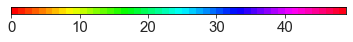

In [1405]:
import matplotlib.pyplot as plt

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def main():
    N = 49
    fig=plt.figure()
    ax=fig.add_subplot(111)   
    plt.axis('scaled')
    ax.set_xlim([ 0, N])
    ax.set_ylim([-0.5, 0.5])
    cmap = get_cmap(N)
    for i in range(N):
        rect = plt.Rectangle((i, -0.5), 1, 1, facecolor=cmap(i))
        ax.add_artist(rect)
    ax.set_yticks([])
    plt.show()

if __name__=='__main__':
    main()

In [1636]:
# Covariance Matrix
cov_mat = vw_returns.cov()
cov_mat_log_returns = log_returns.cov()
std = np.std(industry_port[0], axis=0)
std

Agric     6.433002
Food      4.488661
Soda      6.419781
Beer      5.195570
Smoke     6.239835
Toys      7.384462
Fun       7.871699
Books     6.082556
Hshld     4.682498
Clths     6.728206
Hlth      8.051297
MedEq     5.343804
Drugs     5.003324
Chems     5.791238
Rubbr     6.066879
Txtls     7.653351
BldMt     6.407041
Cnstr     7.343386
Steel     8.009997
FabPr     7.564152
Mach      6.475519
ElcEq     6.513667
Autos     7.789433
Aero      6.920346
Ships     7.397267
Guns      6.525691
Gold     10.753620
Mines     7.721094
Coal     11.212971
Oil       6.315598
Util      4.128641
Telcm     4.815503
PerSv     6.690630
BusSv     5.750425
Hardw     7.210555
Softw    10.156031
Chips     7.607601
LabEq     6.942223
Paper     5.594748
Boxes     5.713559
Trans     5.928419
Whlsl     5.539531
Rtail     5.574624
Meals     6.089126
Banks     6.175548
Insur     5.524328
RlEst     7.690568
Fin       6.336427
Other     6.782367
dtype: float64

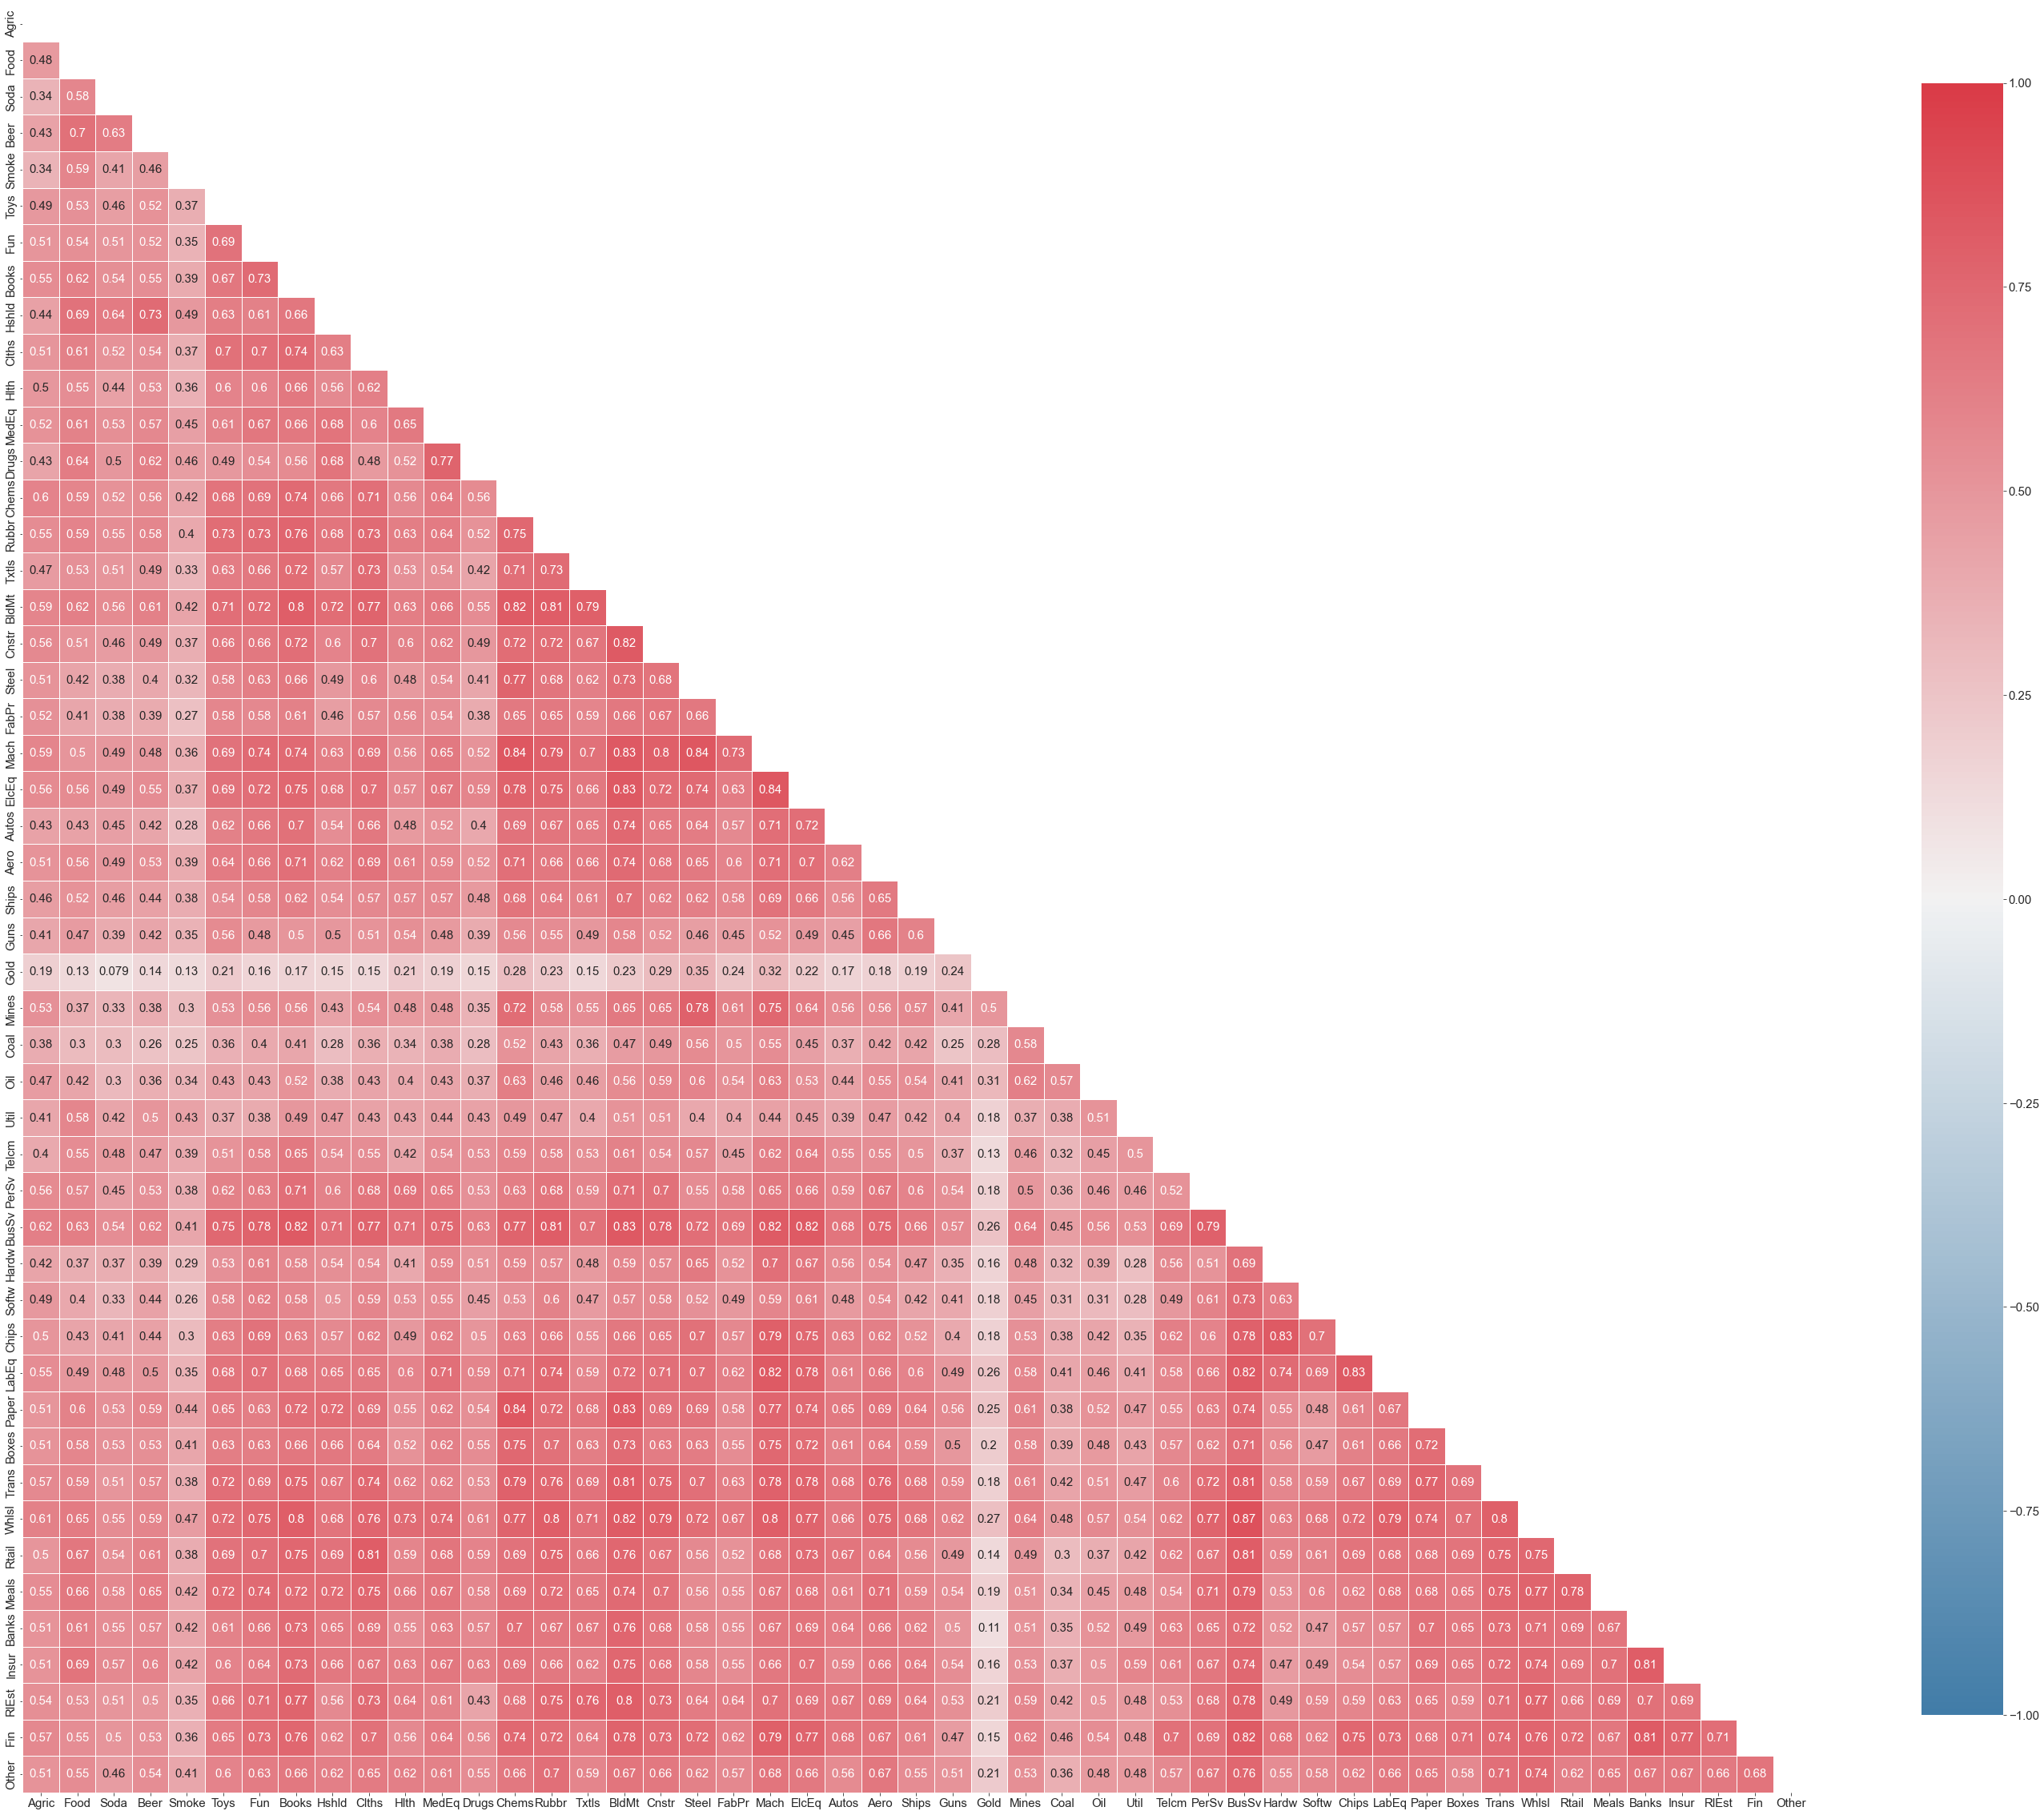

In [1614]:
# Plotting Correlation Matrix

corr_mat = cov_to_corr_matrix(cov_mat)
fig, ax = plt.subplots(figsize=(50, 50))
correlation_plot(corr_mat_log_returns, names=asset_list, include_values=True, ax=ax)

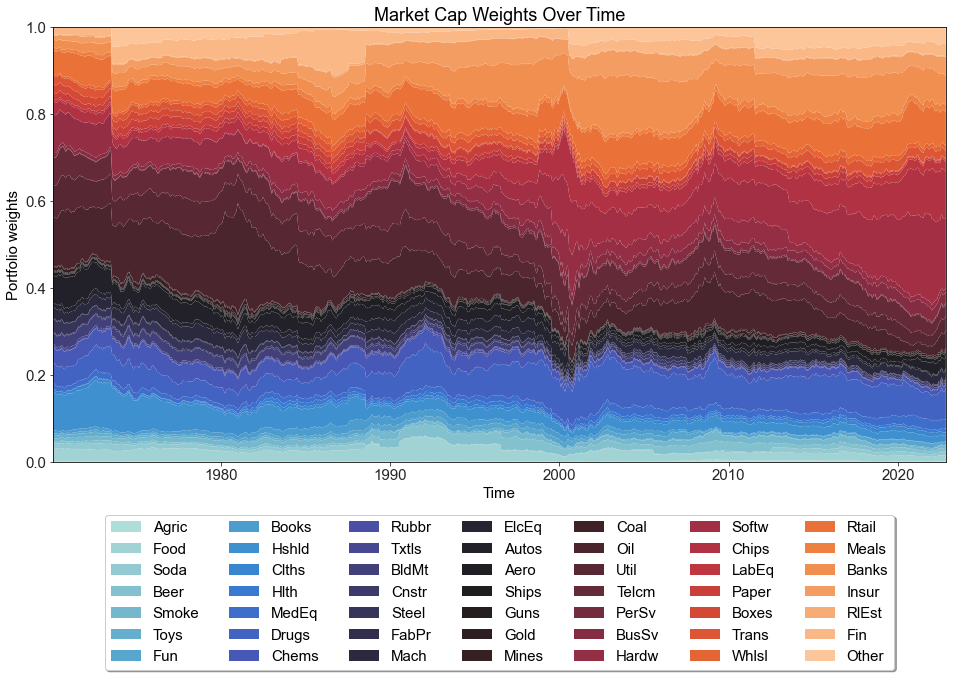

In [1601]:
# Plot Market Cap Weights Over Time 

fig, ax = plt.subplots(figsize=(16, 8))
color_map = sns.color_palette('icefire', 49)
ax.stackplot(dates, w_mc.T,labels=asset_list, colors=color_map);
ax.set_xlabel("Time")
ax.set_ylabel("Portfolio weights")
ax.set_title("Market Cap Weights Over Time");
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=7);

In [693]:
# Sectors that Dominates

w_mc.sum()

Agric     0.976509
Food     15.677386
Soda      3.926562
Beer      8.022698
Smoke     6.699969
Toys      1.862118
Fun       5.142034
Books     5.559192
Hshld    23.238753
Clths     4.161976
Hlth      3.497616
MedEq     8.679446
Drugs    41.993305
Chems    17.699669
Rubbr     1.300106
Txtls     1.361091
BldMt     8.169295
Cnstr     2.465594
Steel     6.349812
FabPr     0.556284
Mach     13.461595
ElcEq     7.402202
Autos    15.512528
Aero      6.987124
Ships     0.849682
Guns      1.680087
Gold      1.284733
Mines     2.717992
Coal      0.732601
Oil      54.494961
Util     33.837436
Telcm    37.855183
PerSv     1.975887
BusSv    11.098811
Hardw    28.819686
Softw    32.946180
Chips    26.616832
LabEq     6.288455
Paper     9.282438
Boxes     3.959881
Trans    11.869083
Whlsl     7.159004
Rtail    38.613643
Meals     7.033560
Banks    42.539753
Insur    24.241022
RlEst     1.013125
Fin      20.932694
Other    15.454405
dtype: float64

In [694]:
# Define ENC Formulas

def calculate_enc(weights: np.ndarray, alpha: int = 1, relative: bool = False) -> float:

    num_constituents = len(weights)
    enc = 0.0

    if alpha <= 0:
        raise ValueError("Alpha must be larger than zero.")
    elif alpha == 1:
        enc = np.exp(entropy(weights, axis = 1))
    else:
        norm = np.linalg.norm(weights, ord=alpha, axis = 1)
        enc = norm**(alpha / (1 - alpha))

    if relative:
        return enc / num_constituents
    else:
        return enc

In [771]:
# Define Weights

weights = np.array(w_mc).astype(float)
weights_eq = np.array(w_eq).astype(float)
min(calculate_enc(weights, 2))

11.367275085678429

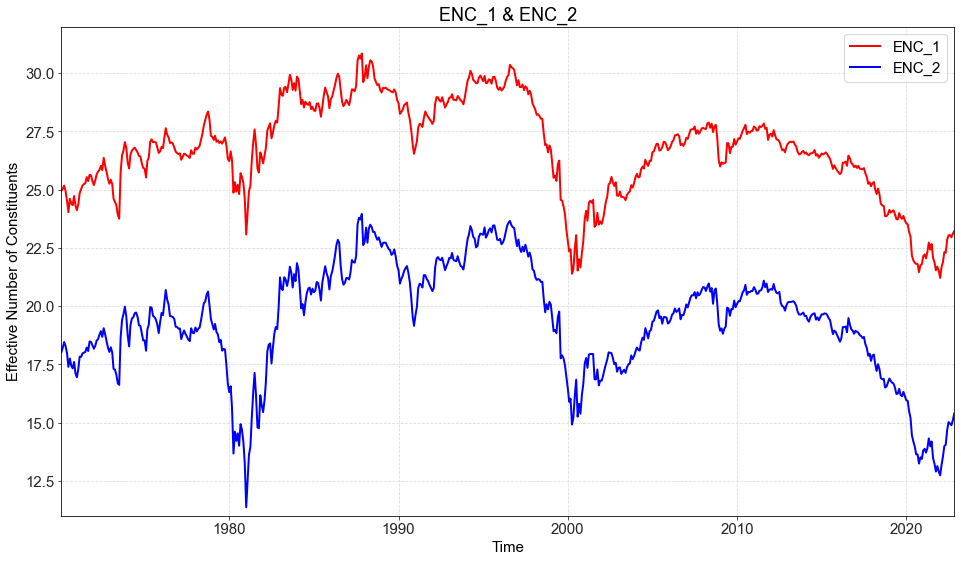

In [757]:
# Plot ENC_2

fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(dates, calculate_enc(weights, 1), color='r', label='ENC_1')
plt.plot(dates, calculate_enc(weights, 2), color='b', label='ENC_2')
plt.ylim((11,32))
plt.xlabel("Time")
plt.ylabel("Effective Number of Constituents")
plt.title("ENC_1 & ENC_2")
plt.legend()

In [1638]:
# Defining Risk Contributions

def calculate_risk_contribution(weights: np.ndarray, cov_matrix: np.ndarray, Months: int) -> np.ndarray:
    
    N = len(dates)
    risk_contr_vector = np.zeros_like(log_returns)
    
    for i in range(Months, N-1, 1):
        return_mat = vw_returns_array[:i,:]
        cov_matrix = np.cov(return_mat.T)
        weights_risk = weights[i-1,:]
    
        total_risk = np.sqrt(weights_risk.T @ cov_matrix @ weights_risk)
        inner_derivative = cov_matrix @ weights_risk
        
        risk_contr = inner_derivative / total_risk
        risk_contr_vector[i,:] = risk_contr * weights_risk * (1/total_risk)
    
    return risk_contr_vector


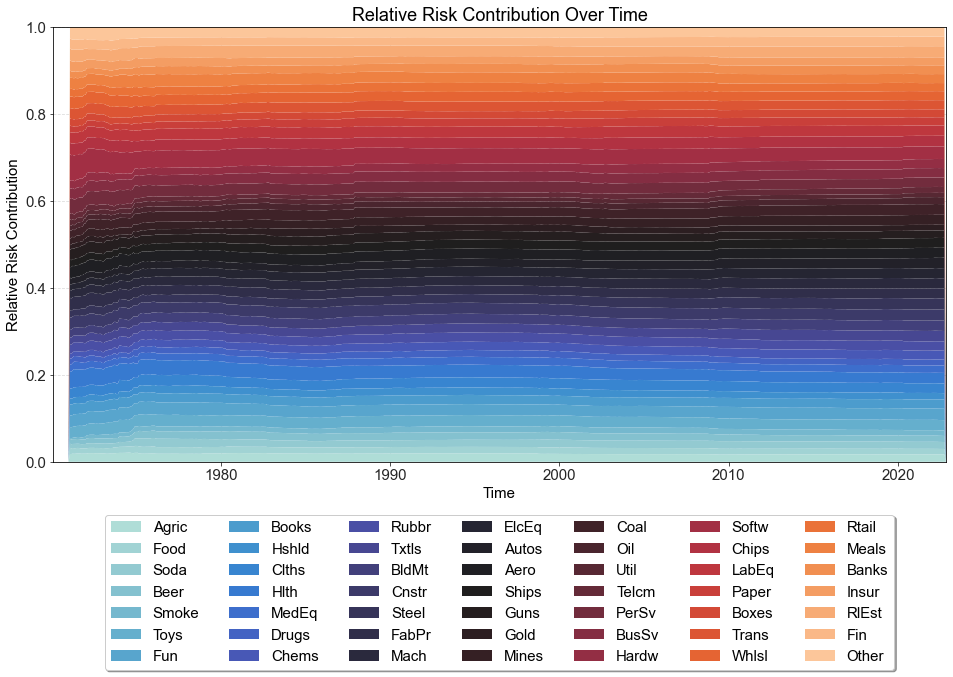

In [1640]:
# Plot The Relative Risk Contribution

rel_risk_contrib = calculate_risk_contribution(weights_eq, cov_mat, 12)

fig, ax = plt.subplots(figsize=(16, 8))
col = plt.cm.CMRmap(np.linspace(0,1,n))
ax.stackplot(dates, rel_risk_contrib.T, labels=asset_list, colors=color_map);
ax.set_xlabel("Time")
ax.set_ylabel("Relative Risk Contribution")
ax.set_title("Relative Risk Contribution Over Time");
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=7);

In [1649]:
# Choueifaty and Coignard (2008) Diversification Measure For An Equally Weighted Portfolio

def calculate_diversitifaction_measure(weights: np.ndarray, returns: np.array, Months: int) -> np.ndarray:
    
    N = len(dates)
    div = np.zeros(N)
    eq_weights = weights 
    
    for i in range(Months, N-1, 1):
        return_mat = vw_returns_array[:i,:]
        cov_matrix = np.cov(return_mat.T)
        weights_eq = weights[i-1,:]
        sigma = np.std(return_mat, axis=0)
    
        total_risk = np.sqrt(weights_eq.T @ cov_matrix @ weights_eq)
        numerator = np.sum(weights_eq * sigma)
        
        div[i] = numerator / total_risk
    
    return div

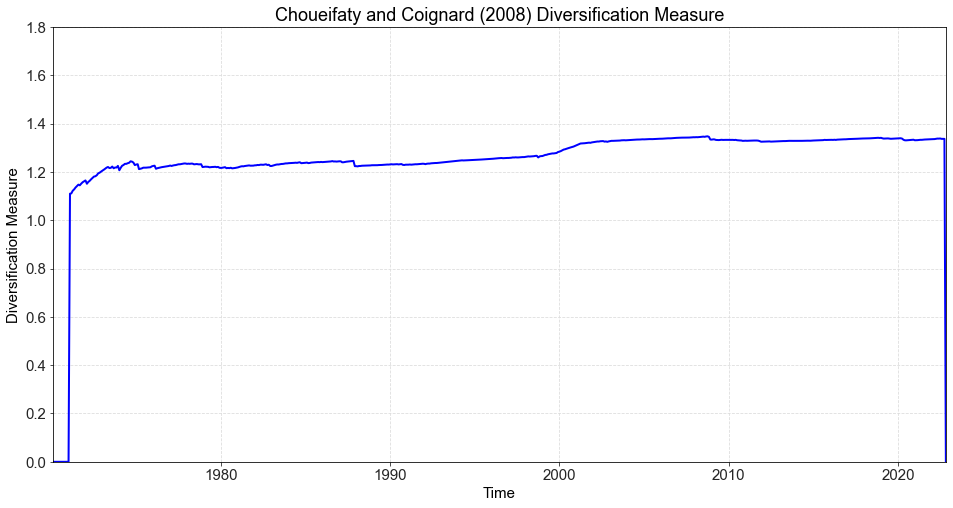

In [1651]:
# Plot The CC Diversification Measure

diversification_measure = calculate_diversitifaction_measure(weights = weights_eq, returns = vw_returns_array, Months = 12)

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(dates, diversification_measure, color='b');
ax.set_ylim(0,1.8)
ax.set_xlabel("Time")
ax.set_ylabel("Diversification Measure")
ax.set_title("Choueifaty and Coignard (2008) Diversification Measure");

In [1694]:
# Defining The Diversification Ratio 

def div_measure(weights: np.ndarray, returns: np.array) -> np.ndarray:

        cov_matrix = cov_mat
        sigma = np.std(returns, axis=0)

        total_risk = np.sqrt(weights @ cov_matrix @ weights.T)
        numerator = np.sum(weights * sigma)
        
        div_m = numerator / total_risk
        
        return div_m

In [1009]:
# Maximizing Diversification Ratio

def div_max(weights: np.ndarray, returns: np.array) -> np.ndarray:
        
        div_min = (-1) * div_measure(weights, returns)
        
        return div_min

In [1012]:
# Most Diversified Portfolio

def most_div_port(weights: np.array, returns_matrix: np.array, Months: int):
    
    N = len(returns_matrix)
    most_div_port = np.zeros_like(weights)
    
    for i in range(Months, N-1, 1):
        ret = returns_matrix[:i,:]
        weights_v = weights[i,:]
        
        bb = Bounds(0,1)
        constraint = ({'type': 'eq','fun': lambda x: np.sum(x) - 1.0})
        
        res = optimize.minimize(div_max, weights_v, args=ret, bounds=bb, method='SLSQP',
                        constraints=constraint)
        
        most_div_port1[i,:] = res.x
        
    return most_div_port1

In [1013]:
# Plotting The Most Diversified Portfolio Weights Over Time

most_div_port1 = most_div_port(weights = weights_eq, returns_matrix = vw_returns, Months = 12)

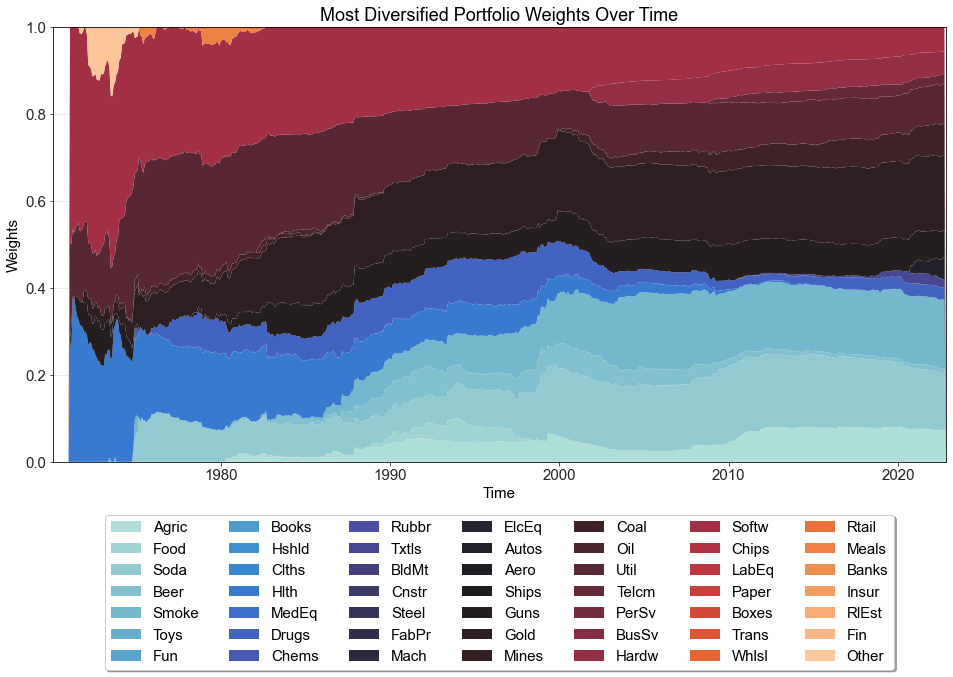

In [1581]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(dates, most_div_port1.T, labels=asset_list, colors=color_map);
ax.set_xlabel("Time")
ax.set_ylabel("Weights")
ax.set_title("Most Diversified Portfolio Weights Over Time");
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=7);

In [1582]:
np.std(vw_returns)

0.0681616938791013

In [1756]:
# Define Minimum Variance Portfolio

def minimum_variance_p(weights: np.array, return_mat: np.array):
    
    cov_matrix = np.cov(vw_returns.T)
    portfolio_var = weights.T @ cov_matrix @ weights
    
    return portfolio_var

In [1757]:
# Define Minimum Variance Portfolio

def minimum_variance_port(weights: np.array, return_mat: np.array):
    
    cov_matrix = np.cov(vw_returns.T)
    portfolio_var = np.dot(weights.T, np.dot(cov_matrix, weights))
    
    return portfolio_var

In [1760]:
# Minimum Variance Portfolio Optimized

def min_var_opt(weights: np.array, returns: np.array, Months: int):
    
    N = len(returns)
    min_var_opt = np.zeros_like(weights)
    
    for i in range(Months, N-1, 1):
        ret = returns[:i,:]
        weights_v = weights[i,:]
        
        bb = Bounds(0,1)
        args = (weights, returns)
        constraint = ({'type': 'eq','fun': lambda x: np.sum(x) - 1.0})
        
        res = optimize.minimize(minimum_variance_p, weights_v, (ret), bounds=bb, method='SLSQP',
                        constraints=constraint)
        
        min_var_opt[i,:] = res.x
        
    return min_var_opt

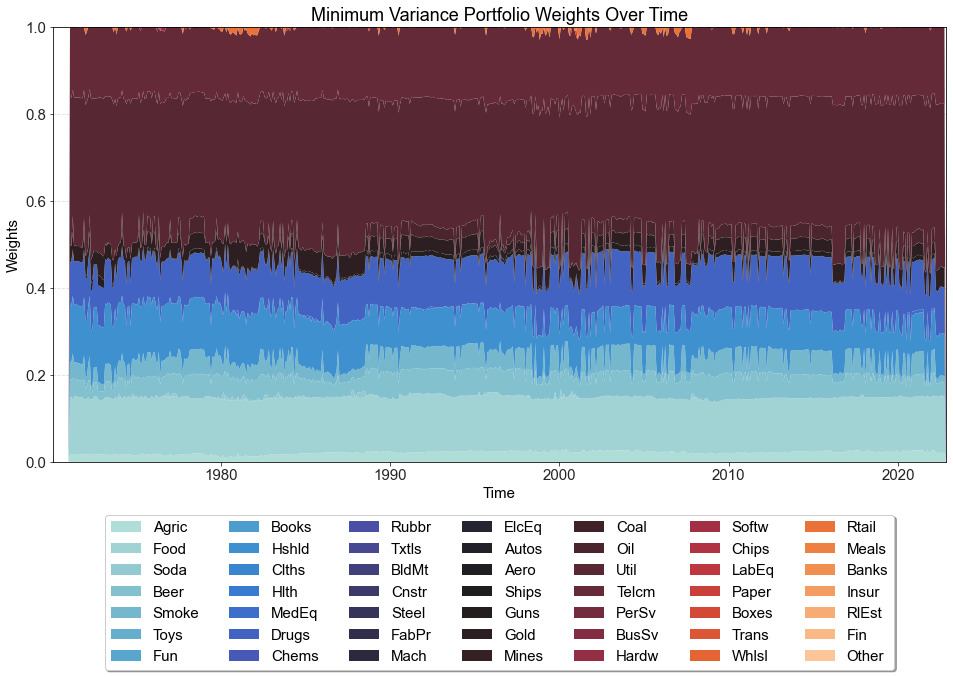

In [1761]:
# Plotting the Weights of The Most Diversified Portfolio Against The Minimum-Variance Portfolio

min_var_opt1 = min_var_opt(weights = weights, returns = vw_returns_array, Months = 12)

fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(dates, min_var_opt1.T, labels=asset_list, colors=color_map);
ax.set_xlabel("Time")
ax.set_ylabel("Weights")
ax.set_title("Minimum Variance Portfolio Weights Over Time")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=7);

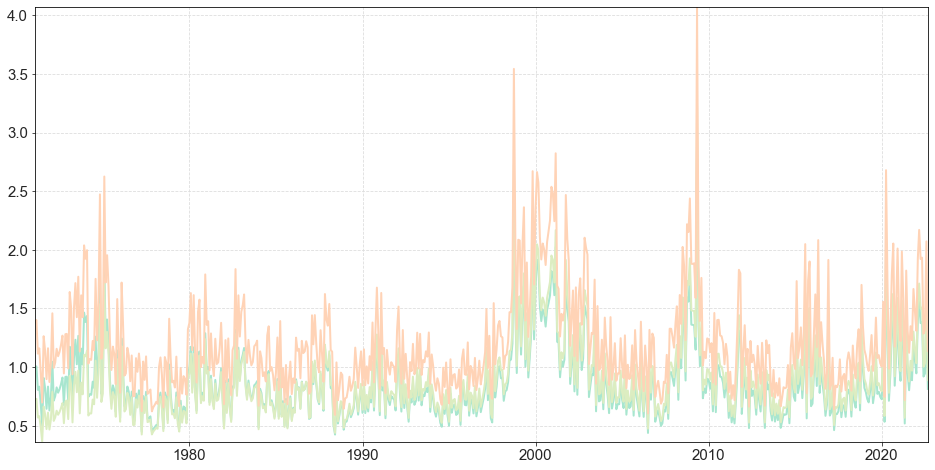

In [1762]:
# Plotting Diversification Measures For The Three Portfolios


N = len(vw_returns)

dm_most_div = np.zeros(len(weights))
dm_eq = np.zeros(len(weights))
dm_min_var = np.zeros(len(weights))

for i in range (12, N-1,1):
    dm_eq[i] = div_measure(weights = weights_eq[i,:], returns = vw_returns_array[i,:])
    dm_most_div[i] = div_measure(weights = most_div_port1[i,:], returns = vw_returns_array[i,:])
    dm_min_var[i] = div_measure(weights = min_var_opt1[i,:], returns = vw_returns_array[i,:])

fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(dates[12:-2],dm_eq[12:-2])
plt.plot(dates[12:-2],dm_most_div[12:-2])
plt.plot(dates[12:-2],dm_min_var[12:-2])
ax.legend
plt.show()

/var/folders/fs/rz1t0hzs0rsdwyxsl8hr4rtc0000gn/T/ipykernel_31820/421079068.py:18: RuntimeWarning: invalid value encountered in double_scalars
  div[i] = numerator / total_risk


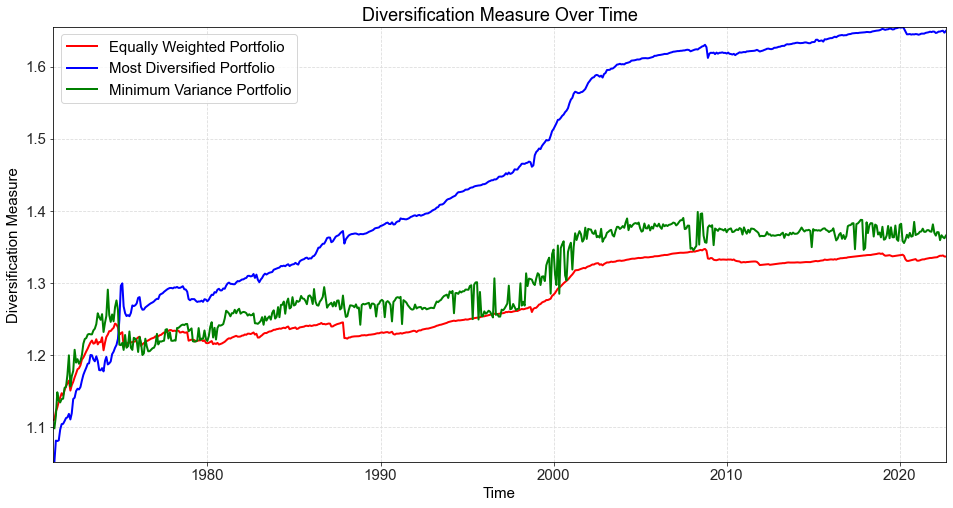

In [1763]:
# Plotting Diversification Measures For The Three Portfolios


dm_eq = calculate_diversitifaction_measure(weights = weights_eq, returns = vw_returns, Months = 12)
dm_most_div = calculate_diversitifaction_measure(most_div_port1, vw_returns, 12)
dm_min_var = calculate_diversitifaction_measure(min_var_opt1, vw_returns, 12)
    
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(dates[12:-2],dm_eq[12:-2],color='r')
plt.plot(dates[12:-2],dm_most_div[12:-2],color='b')
plt.plot(dates[12:-2],dm_min_var[12:-2],color='green')
plt.legend(['Equally Weighted Portfolio','Most Diversified Portfolio','Minimum Variance Portfolio'])
ax.set_xlabel("Time")
ax.set_ylabel("Diversification Measure")
ax.set_title("Diversification Measure Over Time");



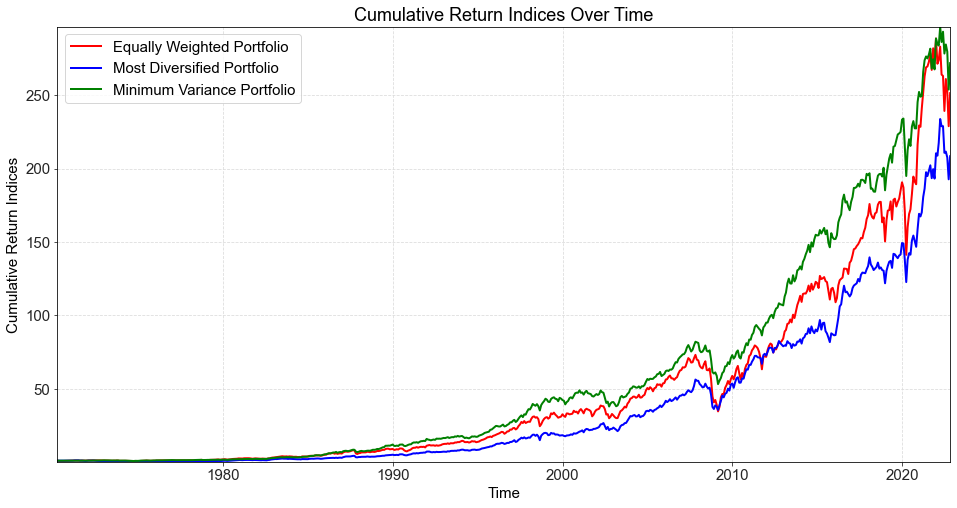

In [1764]:
# Plotting The Cummulative Return of The Three Portfolios

eq_port = weights_eq[1:-1] * vw_returns[2:]
eq_port_ret = eq_port.sum(axis=1)
equally_weighted_ret = (1+eq_port_ret).cumprod()

most_div_port = most_div_port1[1:-1] * vw_returns[2:]
most_div_port_r = most_div_port.sum(axis=1)
most_div_port_ret = (1+most_div_port_r).cumprod()

min_var_port = min_var_opt1[1:-1] * vw_returns[2:]
min_var_port_r = min_var_port.sum(axis=1)
min_var_port_ret = (1+min_var_port_r).cumprod()

fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(dates[2:],equally_weighted_ret, color='r')
plt.plot(dates[2:],most_div_port_ret, color='b')
plt.plot(dates[2:],min_var_port_ret, color='green')
plt.legend(['Equally Weighted Portfolio','Most Diversified Portfolio','Minimum Variance Portfolio'])
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Return Indices")
ax.set_title("Cumulative Return Indices Over Time");

In [1358]:
equally_weighted_ret[631:]

array([251.37917219])

In [1359]:
min_var_port_ret[631:]

array([271.82237988])

In [1342]:
# Calculate The Average Return of The Equally Weighted Portfolio

eq_mean = np.mean(eq_port_ret)
eq_mean

0.010042605269956085

In [1343]:
# Calculate The Average Return of The Most Diversified Portfolio

most_mean = np.mean(most_div_port_r)
most_mean

0.009837156501649383

In [1344]:
# Calculate The Average Return of The Minimum Variance Portfolio

min_mean = np.mean(min_var_port_r)
min_mean

0.009532815521081959

In [1345]:
# Calculate The Standard Deviation of The Equally Weighted Portfolio

eq_std = np.std(eq_port_ret)
eq_std

0.04984769302707079

In [1346]:
# Calculate The Standard Deviation of The Most Diversified Portfolio

most_std = np.std(most_div_port_r)
most_std

0.05202734122466042

In [1347]:
# Calculate The Standard Deviation of The Minimum Variance Portfolio

min_std = np.std(min_var_port_r)
min_std

0.03537559879386546

In [1348]:
# Calculate The Information Ratio of The Equally Weighted Portfolio

ir_eq_port = eq_mean / eq_std
ir_eq_port

0.20146579831693007

In [1350]:
# Calculate The Information Ratio of The Most Diversified Portfolio

ir_most_div_port = np.mean(most_div_port_r) / np.std(most_div_port_r)
ir_most_div_port

0.18907667142111564

In [1095]:
# Calculate The Information Ratio of The Minimum Variance Portfolio

ir_min_var_port = np.mean(min_var_port_r) / np.std(min_var_port_r)
ir_min_var_port

0.26947432258687476

In [1666]:
# Calculate the Turn-Over of The Three Portfolios

N = len(vw_returns)

to_eq = np.zeros(len(vw_returns)) 
to_most_div = np.zeros(len(vw_returns))
to_min_var = np.zeros(len(vw_returns))

for i in range(N):
    eq_port_est = weights_eq[1:] * vw_returns[1:] / (1 + weights_eq[1:]) 
    most_div_est = most_div_port1[1:] * (vw_returns[1:]) / (1 + most_div_port1[1:])
    min_var_est = min_var_opt1[1:] * (vw_returns[1:]) / (1 + min_var_opt1[1:]) 

eq_port_abs = np.abs(eq_port_est - weights_eq[1:])
most_div_abs = np.abs(most_div_est - most_div_port[:1])
min_var_abs = np.abs(min_var_est - min_var_port[:1])

to_eq = np.sum(eq_port_abs) / (len(vw_returns)-1)
to_most_div = np.sum(most_div_abs) / (len(vw_returns)-1)
to_min_var = np.sum(min_var_abs) / (len(vw_returns)-1)
    
to_eq

0.04915801708740368

In [1566]:
to_most_div

0.058258801928514334

In [1567]:
to_min_var

0.0373740699703522